In [3]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


In [4]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[0:7]  # Select the first 6 experiment names

global_config = md.global_config


In [271]:
df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = get_config(exp_name)
    global_config = md.global_config
    model_weights, logs, cfg = md.load_results(exp_name)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, global_config, df=df_result)
    print("====================================")
    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
    eval.printout_eval_report(report, sites, cfg)
    print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())
# Save the transposed DataFrame to a CSV file with optional override
override = False
path = "../results/eval/tables/results_summary.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)

if override:
    df_result.transpose().to_csv(path)
    print("Results saved to", path)
else:
    base, ext = os.path.splitext(path)
    suffix = 1
    new_path = f"{base}_{suffix}{ext}"
    while os.path.exists(new_path):
        suffix += 1
        new_path = f"{base}_{suffix}{ext}"
    df_result.transpose().to_csv(new_path)
    print("Results saved to", new_path)

EVAL REPORT FOR EXPERIMENT:  01_baseline
EVAL REPORT FOR EXPERIMENT:  02_pixel_composites
EVAL REPORT FOR EXPERIMENT:  03_seasonal_composites
EVAL REPORT FOR EXPERIMENT:  04_pixel_and_seasonal_comp
EVAL REPORT FOR EXPERIMENT:  05_support_fmask_dlt
EVAL REPORT FOR EXPERIMENT:  06_support_fmask_dlt_dem
EVAL REPORT FOR EXPERIMENT:  07_aux_task
                                    0                    1                       2                           3                     4                         5                  6
Experiment                01_baseline  02_pixel_composites  03_seasonal_composites  04_pixel_and_seasonal_comp  05_support_fmask_dlt  06_support_fmask_dlt_dem        07_aux_task
MAE [m] (Val)                    3.92                 4.14                    4.01                         3.7                  3.75                       3.7               3.81
MAE [m] (Test)                   4.17                 4.28                     4.0                        3.58             

## 250 again

In [282]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[0:7]  # Select the first 6 experiment names

df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = get_config(exp_name)
    global_config = md.global_config
    model_weights, logs, cfg = md.load_results(exp_name)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, global_config, df=df_result)
    print("====================================")
    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
    eval.printout_eval_report(report, sites, cfg)
    #print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())
# Save the transposed DataFrame to a CSV file with optional override
override = False
path = "../results/eval/tables/results_summary.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)

if override:
    df_result.transpose().to_csv(path)
    print("Results saved to", path)
else:
    base, ext = os.path.splitext(path)
    suffix = 1
    new_path = f"{base}_{suffix}{ext}"
    while os.path.exists(new_path):
        suffix += 1
        new_path = f"{base}_{suffix}{ext}"
    df_result.transpose().to_csv(new_path)
    print("Results saved to", new_path)

EVAL REPORT FOR EXPERIMENT:  01_baseline
EVAL REPORT FOR EXPERIMENT:  02_pixel_composites
EVAL REPORT FOR EXPERIMENT:  03_seasonal_composites
EVAL REPORT FOR EXPERIMENT:  04_pixel_and_seasonal_comp
EVAL REPORT FOR EXPERIMENT:  05_support_fmask_dlt
EVAL REPORT FOR EXPERIMENT:  06_support_fmask_dlt_dem
EVAL REPORT FOR EXPERIMENT:  07_aux_task
                                         0                    1                       2                           3                     4                         5                  6
Experiment                     01_baseline  02_pixel_composites  03_seasonal_composites  04_pixel_and_seasonal_comp  05_support_fmask_dlt  06_support_fmask_dlt_dem        07_aux_task
MAE [m] (Val)                          4.0                 4.13                    3.75                        3.82                  3.81                      3.69               3.73
MAE [m] (Test)                        4.23                 4.27                    3.79                     

## 250 epochs, 48 batchsize

In [15]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[6:7]  # Select the first 6 experiment names
    run_id = "250930_1"

df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = cf.get_config(exp_name)
    global_config = md.global_config
    model_weights, logs, cfg = md.load_results(exp_name, run_id)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name, run_id)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, global_config, df=df_result)
    print("===========================")
    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
    eval.printout_eval_report(report, sites, cfg, run_id)
    #print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())
eval.save_df_result_to_csv(df_result, run_id, override=True)
# Save the transposed DataFrame to a CSV file with optional override
# override = False
# path = "../results/eval/tables/results_summary.csv"
# os.makedirs(os.path.dirname(path), exist_ok=True)

# if override:
#     df_result.transpose().to_csv(path)
#     print("Results saved to", path)
# else:
#     base, ext = os.path.splitext(path)
#     suffix = 1
#     new_path = f"{base}_{suffix}{ext}"
#     while os.path.exists(new_path):
#         suffix += 1
#         new_path = f"{base}_{suffix}{ext}"
#     df_result.transpose().to_csv(new_path)
#     print("Results saved to", new_path)

EVAL REPORT FOR EXPERIMENT:  07_aux_task
                                         0
Experiment                     07_aux_task
MAE [m] (Val)                         3.54
MAE [m] (Test)                        3.68
nMAE [%] (Val)                       16.47
nMAE [%] (Test)                      16.19
RMSE [m] (Val)                        4.82
RMSE [m] (Test)                       5.24
Bias [m] (Val)                       -0.28
Bias [m] (Test)                      -0.34
R2 [-] (Val)                          0.79
R2 [-] (Test)                         0.75
---                                    ---
patch_size                              32
num_bands                               15
batch_size                              48
learning_rate                       0.0008
weight_decay                        0.0002
scheduler_type           ReduceLROnPlateau
scheduler_patience                      15
scheduler_factor                       0.5
scheduler_min_lr                  0.000001
early_stoppin

In [320]:
df = df_result.iloc[:7, :10]

In [396]:
import seaborn as sns
from matplotlib.cm import get_cmap

def plot_experiment_metrics(df):
    """
    Plot MAE, nMAE, RMSE, and Bias for Test and Val in grouped barplots,
    hued by experiment name (first column).
    Args:
        df (pd.DataFrame): DataFrame containing metrics for different experiments.
    """
    metrics = [
        ("MAE [m] (Val)", "MAE [m] (Test)"),
        ("nMAE [%] (Val)", "nMAE [%] (Test)"),
        ("RMSE [m] (Val)", "RMSE [m] (Test)"),
        ("Bias [m] (Val)", "Bias [m] (Test)")
    ]
    metric_labels = ["MAE", "nMAE", "RMSE", "Bias"]

    exp_col = df.columns[0]
    exp_names = df[exp_col].tolist()

    # Define experiment groups and colors
    group_map = {
        0: "Baseline",
        1: "CompositeA",
        2: "CompositeB",
        3: "CompositeC",
        4: "AuxLayerA",
        5: "AuxLayerB",
        6: "MidTraining",
    }
    # Use a set of neutral but visually distinct colors from the 'viridis' colormap

    viridis = get_cmap('nipy_spectral')
    # Custom color indices: 0, 0.25, 0.3, 0.35, 0.6, 0.65, 0.85
    color_indices = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.9]
    group_colors = {group: viridis(idx) for group, idx in zip(group_map.values(), color_indices)}

    # Assign experiment group to each experiment
    exp_to_group = {exp_names[i]: group_map.get(i, "Other") for i in range(len(exp_names))}
    palette = {exp: group_colors[exp_to_group[exp]] for exp in exp_names}

    # Prepare melted dataframe for plotting
    df_melted = pd.melt(
        df,
        id_vars=exp_col,
        value_vars=[m for pair in metrics for m in pair],
        var_name="MetricType",
        value_name="Value"
    )
    df_melted["Metric"] = df_melted["MetricType"].apply(lambda x: x.split()[0])
    df_melted["Group"] = df_melted[exp_col].map(exp_to_group)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    handles, labels = None, None
    for i, (label, _) in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        ax.grid()
        metric_group = df_melted[df_melted["Metric"] == label.split()[0]]
        bar = sns.barplot(
            data=metric_group,
            x="MetricType",
            y="Value",
            hue=exp_col,
            ax=ax,
            palette=palette,
            errorbar=None
        )
        ax.set_title(label.split()[0])
        ax.set_xlabel("")
        ax.set_ylabel("Value")
        ax.tick_params(axis='x', rotation=30)
        
        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
    fig.legend(handles, labels, title="Experiment", loc="center left", bbox_to_anchor=(0.9, 0.5), fontsize='large')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_65841/4137621081.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = get_cmap('nipy_spectral')


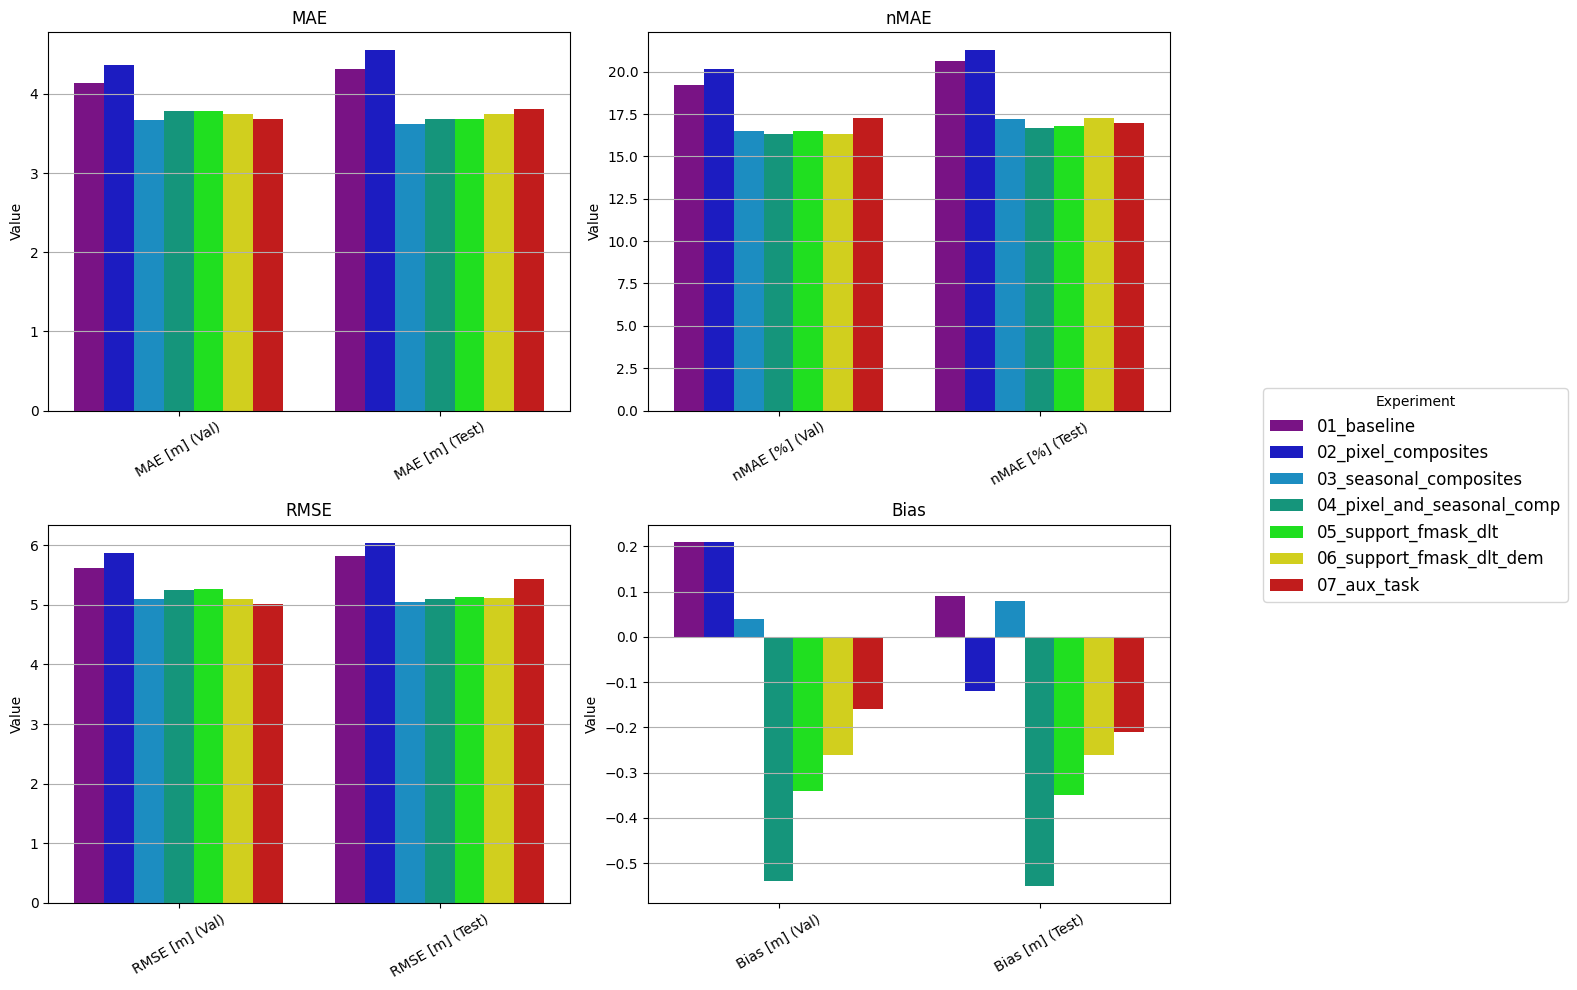

In [397]:
plot_experiment_metrics(df)

## scribblsz

In [146]:
preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks('pixel_and_seasonal')

In [281]:
print(f"Shape of preds_val: {preds_val.shape}")
print(f"Shape of targets_val: {targets_val.shape}")
print(f"Shape of preds_test: {preds_test.shape}")
print(f"Shape of targets_test: {targets_test.shape}")
print(f"Shape of maskval: {maskval.shape}")
print(f"Shape of masktest: {masktest.shape}")

Shape of preds_val: (181, 3, 32, 32)
Shape of targets_val: (181, 3, 32, 32)
Shape of preds_test: (182, 3, 32, 32)
Shape of targets_test: (182, 3, 32, 32)
Shape of maskval: (181, 1, 32, 32)
Shape of masktest: (182, 1, 32, 32)


In [133]:
maskval[:,0,:,:] = maskval[:,0,:,:].astype(np.float32)

In [157]:
preds_test[:,0,:,:].min()

np.float32(22.851805)

In [80]:
cfg["strategy"]

'mid_level'

In [45]:
mu = sites['SITE2']['CHM_norm_params']['mu']
std = sites['SITE2']['CHM_norm_params']['std']


In [34]:
report["experiment_name"]

'baseline'

In [31]:
def save_results(model, val_loader, test_loader, normparams, logs, cfg):

    out_dir = os.path.join("../results/train", cfg['exp'])
    os.makedirs(out_dir, exist_ok=True)

    # Save model weights
    torch.save(model.state_dict(), os.path.join(out_dir, "model.pth"))

    # Save logs and cfg as JSON
    with open(os.path.join(out_dir, "logs.json"), "w") as f:
        json.dump(logs, f)
    with open(os.path.join(out_dir, "cfg.json"), "w") as f:
        json.dump(cfg, f)

    # Optionally, save predictions and targets for val/test sets
    preds_val, targets_val = get_predictions_and_targets(val_loader, model, normparams)
    preds_test, targets_test = get_predictions_and_targets(test_loader, model, normparams)

    # Zip predictions and targets for val/test sets and save as .npz files
    np.savez(os.path.join(out_dir, "val_preds_targets.npz"), preds_val=preds_val, targets_val=targets_val)
    np.savez(os.path.join(out_dir, "test_preds_targets.npz"), preds_test=preds_test, targets_test=targets_test)

    print("Results saved to:", out_dir)

def load_np_stacks(exp_dir):
    """
    Loads prediction and target numpy arrays from the experiment results folder.
    Returns preds_val, targets_val, preds_test, targets_test as numpy arrays.
    """
    out_dir = os.path.join("../results/train", exp_dir)
    val_npz = np.load(os.path.join(out_dir, "val_preds_targets.npz"))
    test_npz = np.load(os.path.join(out_dir, "test_preds_targets.npz"))
    preds_val = val_npz["preds_val"]
    targets_val = val_npz["targets_val"]
    preds_test = test_npz["preds_test"]
    targets_test = test_npz["targets_test"]
    return preds_val, targets_val, preds_test, targets_test

def load_results(exp_dir):
    """
    Loads model weights, logs, and cfg from the experiment results folder.
    """
    out_dir = os.path.join("../results/train", exp_dir)
    model_weights = torch.load(os.path.join(out_dir, "model.pth"))
    with open(os.path.join(out_dir, "logs.json"), "r") as f:
        logs = json.load(f)
    with open(os.path.join(out_dir, "cfg.json"), "r") as f:
        cfg = json.load(f)
    return model_weights, logs, cfg

def ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test):
    """
    Compile a new evaluation report for the given experiment.
    """
    report = {
        "experiment_name": exp_name,
        "model_weights": model_weights,
        "logs": logs,
        "config": cfg,
        "predictions": {
            "validation": preds_val,
            "test": preds_test
        },
        "targets": {
            "validation": targets_val,
            "test": targets_test
        }
    }
    return report